## YUV color space
Colors in images can be encoded in different ways. Most well known is perhaps the RGB-encoding, in which the image consists of a Red, Green, and Blue channel. However, there are many other encodings, which sometimes have arisen for historical reasons or to better comply with properties of human perception. The YUV color space has arisen in order to better deal with transmission or compression artifacts; when using YUV instead of RGB, these artifacts will less easily be detected by humans. YUV consists of one luma component (Y) and two chrominance (color) components (UV). 

Many cameras used in robotics directly output YUV-encoded images. Although these images can be converted to RGB, this conversion costs computation time, so it is better to work directly in YUV-space. The YUV color space is aptly explained on <A HREF="https://en.wikipedia.org/wiki/YUV" TARGET="_blank">Wikipedia</A>. It also contains an image on the U and V axes, for a value of Y$=0.5$. However, using this image for determining thresholds on U and V for color detection may lead to suboptimal results. 

<font color='red'><B>Exercise 1</B></font>
Generate slices of the YUV space below, with the help of the script `YUV_slices.py` <A HREF="https://github.com/guidoAI/YUV_notebook/blob/master/YUV_slices.py" TARGET="_blank">(link to file)</A>. You can change the number of slices (`n_slices`) and the height and width (`H`, `W`) of the generated images. 

1. Why can determining thresholds at Y$=0.5$ lead to suboptimal results?
2. What U and V thresholds would you set for detecting orange? And for green?
3. Can you think of a better way than setting a threshold on U and V for determining if a pixel belongs to a certain color?


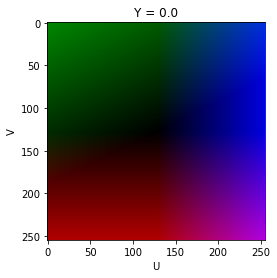

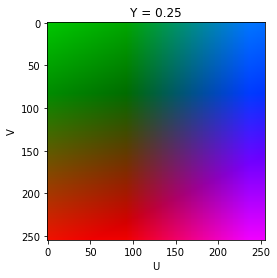

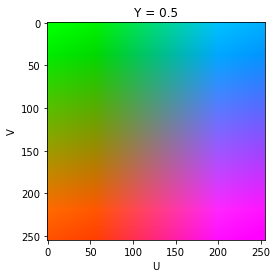

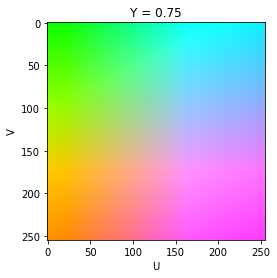

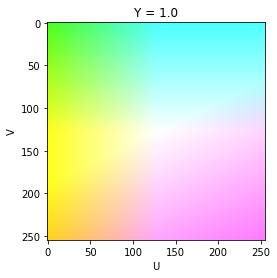

In [1]:
%matplotlib inline
import YUV_slices as YUV

n_slices = 5;
YUV.generate_slices_YUV(n_slices);

## Color filtering

The code below loads an image and filters the colors. 

In [87]:
%matplotlib inline
import cv2;
import numpy as np;
import matplotlib.pyplot as plt
#BlackPanel
#OrangePole
def canny_edge(image_name = 'training_white.jpg'):
    im = cv2.imread(image_name);
    YUV = cv2.cvtColor(im, cv2.COLOR_BGR2YUV);
    
    Y = YUV[:,:,0]
    U = YUV[:,:,1]
    V = YUV[:,:,2]
    
    # blurring the iamge with a 10 by 10 kernal to reduce the noice in the edge detection algorithm
    # kernal size is chosen with a educated gues. 
    Yblur = cv2.blur(Y, (10,10))
    
    # canny edge detection version:
    # function that finds the edges. 
    Yedges = cv2.Canny(Yblur, 100, 150, apertureSize=5)
    
    # creates contours from the edges. it connects the edges by drawing lines. 
    contours, hierarchy = cv2.findContours(Yedges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # draw countours to visualize the algortighm Yedges makes them thick
    cv2.drawContours(Yedges, contours, -1, (255, 255, 255), 3)
    
    
    
    
    
    plt.figure()
    plt.imshow(Y, cmap='gray');
    plt.title('Gray image');
    
    plt.figure()
    plt.imshow(Yedges, cmap='gray');
    plt.title('Gray image');
    
    plt.figure()
    plt.imshow(Yedges, cmap='gray');
    plt.title('Gray image');
    
    return Yedges

def color_edge(image_name = 'training_white.jpg'):
    im = cv2.imread(image_name);
    YUV = cv2.cvtColor(im, cv2.COLOR_BGR2YUV);
    
    Y = YUV[:,:,0]
    U = YUV[:,:,1]
    V = YUV[:,:,2]
    
    # blurring the iamge with a 10 by 10 kernal to reduce the noice in the edge detection algorithm
    # kernal size is chosen with a educated gues. 
    Yblur = cv2.blur(Y, (10,10))
    
    # one can use also a color detection difference version instead of canny edge detection
    ret, Ycolor_dif = cv2.threshold(Yblur, 100, 200, cv2.THRESH_BINARY_INV)
    # finding the contours with colour diff
    #contours, hierarchy = cv2.findContours(Ycolor_dif, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    #Ycolor_difcache = Ycolor_dif
    #Yobject = cv2.fillPoly(Ycolor_dif, pts =contours, color=(255,255,255))
    #cv2.drawContours(Ycolor_dif, contours, -1, (255, 255, 255), 3)
    
    
    
    plt.figure()
    plt.imshow(Y, cmap='gray');
    plt.title('Gray image');
    
    plt.figure()
    plt.imshow(Ycolor_dif, cmap='gray');
    plt.title('Gray image');
    
    plt.figure()
    plt.imshow(Yedges, cmap='gray');
    plt.title('Gray image');
    return Ycolor_dif

def self_edge(white_treshhold,edge_length ,edge_threshhold, bin_size, image_name = 'training_white.jpg'):
    im = cv2.imread(image_name);
    YUV = cv2.cvtColor(im, cv2.COLOR_BGR2YUV);
    
    Y = YUV[:,:,0]
    U = YUV[:,:,1]
    V = YUV[:,:,2]
    Yp = YUV[:,:,0]
    preY = YUV[:,:0]
    zone_count = [0, 0, 0, 0, 0]
    white_count = 0
    image_width = Y.shape[1]
    
    yp_memory_list = np.empty(image_width)
    print(Y.shape)
    for y in range(Y.shape[0]):
        
        # for each row the previous illumation  0;
        
        previous_Y = 0;
        dY = 0;
        #move along the x axis
        for x in range(Y.shape[1]):
            #current Y value
            yp = int(Y[x,y])
            #print(x)
            yp_memory_list[x-1] = yp
            
            
            if((x + edge_length + 1) > 0):
                slice = yp_memory_list[x-edge_length:x]
                #print(slice)
                
                yp_mean = np.mean(yp_memory_list[(x-edge_length):x])
                yp_previous = np.mean(yp_memory_list[x-edge_length-1:x-1])
                
                #Image output
                Yp[x,y] = yp
                
                #//Calculate difference in pixel lumination
                dY = abs(yp_mean - yp_previous);
                #print(dY)
                U[x,y] = 0 #make U black 
                
                #//Check if the difference above a certain treshhold
                if dY >= edge_threshhold:
                    U[x,y] = 255 #draw the edges.
                    #// Find where the edge is
                    if x >= 0 and x <= bin_size:
                        zone_count[0]+=1
    
                    elif x > bin_size and x <= 2 * bin_size:
                        zone_count[1]+=1
        
                    elif x > (2 * bin_size) and x<= (3 * bin_size):
                        zone_count[2]+=1;
        
                    elif x > (3 * bin_size) and x<= (4 * bin_size): 
                        zone_count[3]+=1;
                    else:
                        zone_count[4]+=1;
                    
            #previous_Y = yp

            #check for white spaces
            if Y[x,y] >= white_treshhold:
                #U[y,x] = 255 
                white_count+=1
                
            #preY[x,y] = previous_Y
        
    plt.figure()
    plt.imshow(Y, cmap='gray');
    plt.title('Gray image');
    
    #plt.figure()
    #plt.imshow(preY, cmap='gray');
    #plt.title('Gray image');
    
    plt.figure()
    plt.imshow(Yp, cmap='gray');
    plt.title('Gray image');
    
    return zone_count, U, white_count

<font color='red'><B>Exercise 2</B></font>

Please answer the questions of this exercise, by changing and running the code block below. Note that Y, U, and V are all in the range $[0, 255]$.

1. Can you find an easy way to make the code run faster, while still being able to evaluate if your filter works?
2. Can you filter the colors, so that only the tulip remains?
3. Can you filter the colors, so that only the stem remains?

In [88]:
#Yobject = canny_edge();
count, Yedge, white_count = self_edge(220,8,5, 104,"test2.jpg")

plt.figure()
plt.imshow(Yedge, cmap='gray');
plt.title('Gray image');

print(count)
print(np.argmin(count))
print(white_count)

TypeError: object of type 'int' has no len()

## Answers
Exercise 1:
1. Colors and color regions are different for different Y values. What is orange at one value of Y can be a different color (e.g., red) at another value of Y.
2. Green: low U, low V (e.g., [0,120], [0,120]). Orange: low U, relatively high V (e.g., [0,120], [160,220])
3. Include the Y in the selection of the threshold, e.g., as in a look-up table (different U and V depending on Y), or by determining a prototype pixel for each different "color" and when classifying a pixel, determining which prototype is closest in YUV-space.

Exercise 2:
1. Set the resize_factor to a factor larger than 1. Setting it to 4 makes the filtering faster, while it is still possible to evaluate the success of the filter. 
2. ``y_low = 50, y_high = 200, u_low = 0, u_high = 120, v_low = 160, v_high = 220``
3. ``y_low = 50, y_high = 200, u_low = 0, u_high = 120, v_low = 0, v_high = 120``

In [4]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
# block that will count the white pixels in the different quadrants of the image
Yobject = np.array(Yobject)
#Yobject.shape[0] = height
#Yobject.shape[1] = with
#print(Yobject.shape)
window_with = Yobject.shape[1] / 3
#print(window_with)
objects_count = []
for i in range(3):
    window = Yobject[0:, i*int(window_with):(i+1)*int(window_with)]
    print(window.shape)
    count = window.sum()
    objects_count.append(count)
    
print(objects_count)
print(np.argmin(objects_count))
print(3*104, 4*104)




NameError: name 'Yobject' is not defined